In [4]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt 
# import cv2
import numpy as np

In [5]:
img_height = 224
img_width = 224
input_shape = (img_width, img_height, 3)
batch_size = 32
train_dir = pathlib.Path('../input/cacao-augmented-224/training_img/training_img/')
test_dir  = pathlib.Path('../input/cacao-augmented-224/testing_img/testing_img/')
checkpoint_dir = pathlib.Path('./cacao_CAE/checkpoint')
model_dir = pathlib.Path('./cacao_CAE/model.h5')


In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  labels=None,
    seed=252,
  shuffle=True,
    validation_split=0.2,
    subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


In [25]:
input_layer = layers.Input(shape=input_shape)
input_layer2 = layers.Rescaling(scale=1./255, offset=0)(input_layer)
# encoder
x = layers.Conv2D(112, kernel_size=(7,7), padding="same")(input_layer2)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(96, kernel_size=(7,7), padding="same")(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(28, kernel_size=(5,5), padding="same")(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(14, kernel_size=(5,5), padding="same")(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D( 1, kernel_size=(3,3), padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(84, activation="relu")(x)
# #latent
latent = layers.Dense(56, activation="softmax")(x)
# #decoder
x = layers.Dense(84, activation="relu")(latent)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(784, activation="relu")(x)
x = layers.Reshape((28,28,1))(x)
x = layers.Conv2DTranspose(14, kernel_size=(5,5), strides=1, padding="same")(x)
x = layers.Conv2DTranspose(28, kernel_size=(5,5), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(96, kernel_size=(7,7), strides=2, padding="same")(x)
x = layers.Conv2DTranspose(112, kernel_size=(7,7), strides=2, padding="same")(x)

output_layer = layers.Conv2D(3, kernel_size=(5,5), padding="same")(x)
output_layer = layers.Rescaling(scale=255, offset=0)(output_layer)

model = keras.Model(input_layer, output_layer)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["mse"])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling_10 (Rescaling)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 224, 224, 112)     16576     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 224, 224, 112)     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 96)      526944    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 224, 224, 96)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 96)      0   

In [ ]:
model = keras.models.load_model(model_dir)

In [28]:
epochs = 1
i=100
for ep in range(epochs):
  print("Epoch",ep+1, "/", epochs)
  for batch in train_ds.take(100):
      i = i+1
      score = model.train_on_batch(x=batch, y=batch, reset_metrics=False, return_dict=False)
      print("batch",i, "--MSE:",score[0])

model.save(model_dir)

Epoch 1 / 1
batch 101 --MSE: 38.74150466918945
batch 102 --MSE: 38.711151123046875
batch 103 --MSE: 38.68745803833008
batch 104 --MSE: 38.692623138427734
batch 105 --MSE: 38.67601776123047
batch 106 --MSE: 38.680213928222656
batch 107 --MSE: 38.62978744506836
batch 108 --MSE: 38.58689498901367
batch 109 --MSE: 38.569488525390625
batch 110 --MSE: 38.59059524536133
batch 111 --MSE: 38.56903839111328
batch 112 --MSE: 38.571258544921875
batch 113 --MSE: 38.57131576538086
batch 114 --MSE: 38.53507995605469
batch 115 --MSE: 38.549808502197266
batch 116 --MSE: 38.50621795654297
batch 117 --MSE: 38.48682403564453
batch 118 --MSE: 38.518245697021484
batch 119 --MSE: 38.526817321777344
batch 120 --MSE: 38.51781463623047
batch 121 --MSE: 38.48917007446289
batch 122 --MSE: 38.48857879638672
batch 123 --MSE: 38.48542785644531
batch 124 --MSE: 38.43680191040039
batch 125 --MSE: 38.430362701416016
batch 126 --MSE: 38.4010124206543
batch 127 --MSE: 38.39399719238281
batch 128 --MSE: 38.393184661865234

In [11]:
model.save(model_dir)

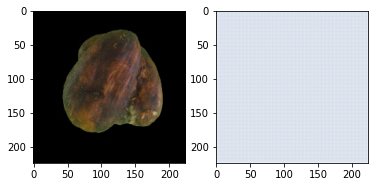

In [29]:
for img in train_ds.take(1):
    image = img
    break

result = model.predict(image, batch_size=None)

# print(np.shape(result))
image = np.asarray(image[0], dtype="uint8")
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
result = np.asarray(result[0], dtype="uint8")
plt.imshow(result)
